# RC-RC Cascade Circuit Controller
## Introduction
The goal of this project is to apply a number of digital control concepts 
using an RC-RC cascade circuit as the target plant, so as to improve it's
rise time by at least 30%, while keeping the stationary state error at zero
and an overshoot lower than 5%. 

The project consists of three components:
* Embedded Software application used to interact with the plant.
* Datavis Python Application: used to collect data sent throgh UART by the
Embedded system. 
* Jupyter Notebook: used for modeling the system and analyzing the data 
obtained with the Embedded application.


## Plant Description
The following diagram depicts the Plant circuital model

![plant](./img/Plant.png)

The input signal is provided by MCU, and it varies depending on the anlysis
being performed.  

In [122]:
# Environment 
## Import
import numpy as np
import control
import matplotlib.pyplot as plt
import typing
import pandas as pd
from scipy.linalg import expm

## Constants
SR_F_HZ = 1000  # System sampling frequency. 
SQ_WAVE_F_HZ = 10 # Reference signal frequency.
SAMPLES_PER_PERIOD = SR_F_HZ // SQ_WAVE_F_HZ  # Number of samples per reference
                                              # signal period.

## Data structure modeling datavis.py's csv format.
SampledData = typing.Dict[typing.Literal['Time', 'ADC', 'DAC'], 
                          np.ndarray] 

## Utility to extract a given number of periods from sampled .csv data.
def extract_data(df: pd.DataFrame, periods:float=1, samples_offset:int=0) -> SampledData:
    nsamples = int(periods * SAMPLES_PER_PERIOD)
    return {
        'Time':np.arange(nsamples) * 1 / SR_F_HZ,
        'ADC': np.array(df['ADC'][samples_offset:samples_offset+nsamples]),
        'DAC': np.array(df['DAC'][samples_offset:samples_offset+nsamples]) 
    }

# Risetime calculation utility
def calc_risetime(data: np.ndarray, timearr: np.ndarray):
    v10 = (data.max() - data.min())*.1 + data.min()
    v90 = (data.max() - data.min())*.9 + data.min()
    t10_i = np.argmin(np.abs((data - v10))) 
    t90_i = np.argmin(np.abs((data - v90))) 
    return timearr[t90_i] - timearr[t10_i] , (t10_i, t90_i) 

# Risetime plot generation. Returns the risetime value.
def plot_risetime(d: SampledData, title) -> float:
    tr, (t10_i, t90_i) = calc_risetime(d['ADC'], d['Time'])
    plt.figure(figsize=(20, 5))
    plt.plot(d['Time'], d['ADC'], '-o')
    plt.axvline(d['Time'][t10_i], color='red', linestyle='--')
    plt.axvline(d['Time'][t90_i], color='red', linestyle='--')
    plt.axvspan(d['Time'][t10_i], d['Time'][t90_i], facecolor='blue', alpha=0.2)
    plt.plot(d['Time'][t10_i], d['ADC'][t10_i], 'o', markersize=20)
    plt.plot(d['Time'][t90_i], d['ADC'][t90_i], 'o', markersize=20)
    plt.title(f'{title} - Rise Time: <{tr * 1000:.2f}> ms')
    plt.ylabel('Magnitude')
    plt.xlabel('Time [Sec]')
    plt.grid()
    return tr



# Risetime Analysis/Calculation

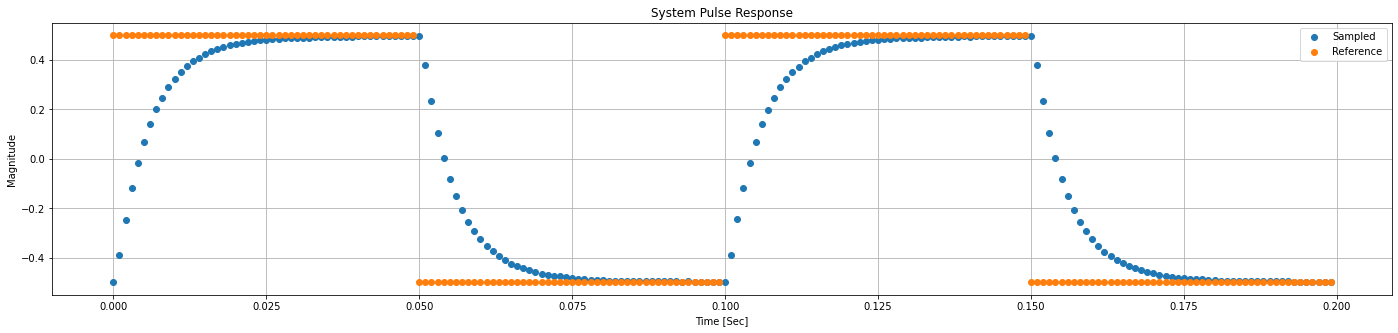

In [123]:
# Load data 
data = pd.read_csv('csvs/step_resp.csv')
step_resp_data = extract_data(data, periods=2)

# Simple plot.  
plt.figure(figsize=(24, 5))
plt.plot(step_resp_data['Time'], step_resp_data['ADC'], 'o', label='Sampled')
plt.plot(step_resp_data['Time'], step_resp_data['DAC'], 'o', label='Reference')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()
plt.grid()

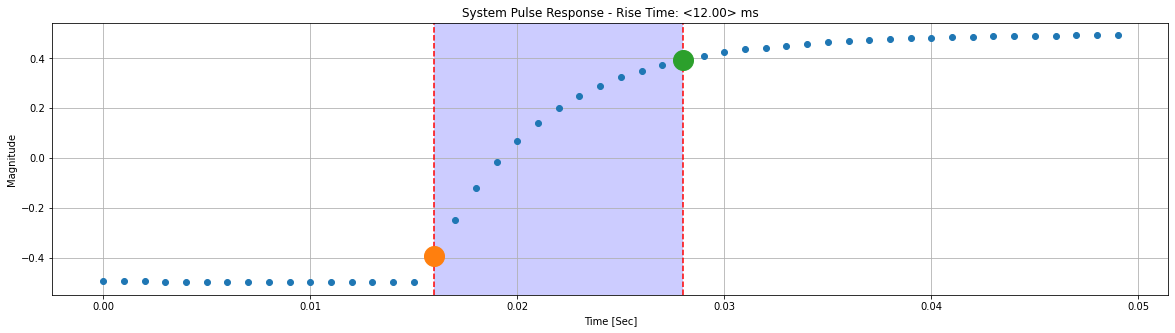

In [124]:
# Extract a single rising step to analyze rise time behavior.
step_resp_half_cycle = extract_data(data, 1/2, samples_offset=185)
rs, (t1, t2) = calc_risetime(step_resp_half_cycle['ADC'], step_resp_half_cycle['Time'])

# Plotting. 
plt.figure(figsize=(20, 5))
plt.plot(step_resp_half_cycle['Time'], step_resp_half_cycle['ADC'], 'o')
plt.axvline(step_resp_half_cycle['Time'][t1], color='red', linestyle='--')
plt.axvline(step_resp_half_cycle['Time'][t2], color='red', linestyle='--')
plt.axvspan(step_resp_half_cycle['Time'][t1], step_resp_half_cycle['Time'][t2], facecolor='blue', alpha=0.2)
plt.plot(step_resp_half_cycle['Time'][t1], step_resp_half_cycle['ADC'][t1], 'o', markersize=20)
plt.plot(step_resp_half_cycle['Time'][t2], step_resp_half_cycle['ADC'][t2], 'o', markersize=20)
plt.title(f'System Pulse Response - Rise Time: <{rs * 1000:.2f}> ms')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

# Model Identification: LS Method 
* A real time LS algorithm was used to estimate the plant's parameters 

## Specs

| Parameter               | Value     |
|-------------------------|-----------|
| Sampling time           | 1ms       |
| Algorithm update rate   | 1ms       |
| Filter order            | 2         |
| Filter type             | ARMA      |
| Input signal            | PRBS      |
| PRBS update rate        | 1ms       |
| Input signal range      | Full range|

The model responds to the following equation:
$$ y[n] + a_1 y[n-1] + a_2 y[n-2] = b_0 x[n] + b_1 x[n-1] + b_2 x[n-2] $$ 

The transfer function looks as follows:
$$ H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{a_0 + a_1 z^{-1} + a_2 z^{-2}} $$

## Plant PRBS Response 
The following cell shows how the system responded to the PRBS signal while
estimating the LS Coefficients.


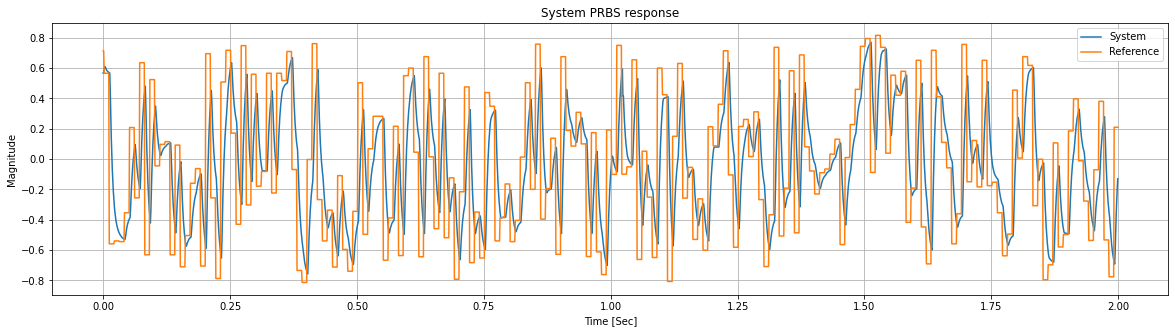

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000

# Datos capturados de la respuesta del sistema a la señal PRBS.
data2 = pd.read_csv('csvs/ls_output_data.csv')
plt.figure(figsize=(20, 5))
plt.plot(data2[:2000]['Time'], data2[:2000]['ADC'], label='System')
plt.plot(data2[:2000]['Time'], data2[:2000]['DAC'], label='Reference')
plt.grid()
plt.title('System PRBS response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()


# System Modeling Analysis: Theory vs Practice
The following cell compares the step response of:
* The theoretical system, using a continuous model and assuming that both the
components and that the plant in general are ideal
* The plant simulated using the LS acquired parameters
* The actual response of the plant, as sampled by the MCU's ADC

Polo Teórico S 0: 362.997Hz
Polo Teórico S 1: 34.891Hz
Polo Teórico Z 0: 401.571Hz
Polo Teórico Z 1: 51.102Hz
Polo Empírico 0: 418.565Hz
Polo Empírico 1: -209.462Hz


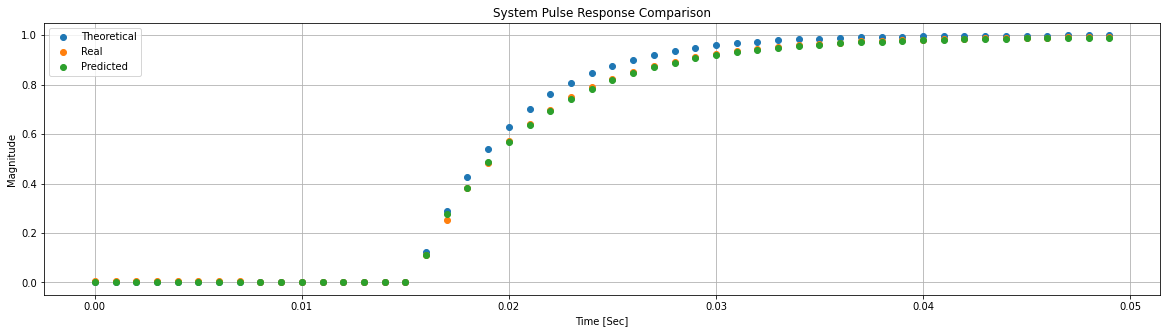

In [96]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt
from scipy import signal

## Sistema Teórico

# Componentes
r_1, c_1, r_2, c_2 = 10e3, 100e-9, 10e3, 200e-9

# Transferencia teórica
s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)

# Polos
for i, pole_hz in enumerate(poles(hs_1) / (2*np.pi)):
    print(f'Polo Teórico S {i}: {float(-pole_hz.real):.3f}Hz')

# Transferencia teórica discretizada
hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
for i, pole_hz in enumerate((poles(hz_1) * SR_F_HZ / 2)):
    print(f'Polo Teórico Z {i}: {float(pole_hz.real):.3f}Hz')


# Transferencia reconstruida por LS del modelo
knum = [0.00098912, 0.110023150, 0.11815254]
den = [1, -0.41820698, -0.35069335]
rls_tf = tf(np.array(knum), np.array(den), dt=1/SR_F_HZ)
ss_rls = tf2ss(rls_tf) 
for i, pole_hz in enumerate(poles(rls_tf)* SR_F_HZ / 2):
    print(f'Polo Empírico {i}: {float(pole_hz.real):.3f}Hz')

sd3 = extract_data(data, periods=1/2, samples_offset=185)
sd3n = normalize(sd3)

# Comparamos la respuesta al escalón con las anteriores
t, hz_out = forced_response(hz_1, sd3n['Time'], sd3n['DAC'])
t2, s = forced_response(rls_tf, sd3n['Time'], sd3n['DAC'])
plt.figure(figsize=(20, 5))
plt.plot(t, hz_out[:len(sd3n['Time'])], 'o', label='Theoretical')
plt.plot(sd3n['Time'], sd3n['ADC'], 'o', label='Real')
plt.plot(t2, s, 'o', label='Predicted')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

An analysis of the system's performance reveals that the predicted curve closely matches the real curve. However, the theoretical curve exhibits a slightly faster response than the actual response of the system. This difference is attributed to the non-ideal nature of the system and the 5% tolerance of the component values, which can significantly affect the placement of the system's poles and zeroes.

## Sampling Time Choice 

Sampling Time minimum and maximum values are chosen based on the following criteria.

- Maximum: the MCU Software shall be able to capture between 4 and 20 samples during the rise interval of the plant when a step reference signal is used. More is unnecessary. 
- Minimum: the MCU must be able to update the DAC, sample the ADCs and run the PID compute algorithm in between two consecutive sampling cycles. In this case in particular, it's also desirable to report sampled values through UART for further analysis, so that must also fit in the aforementioned time window.

In summary:

$T_{max} = T_r \times 0.7 / (4, 20)$ 

$T_{min} = 2 \times T_{adc} + T_{dac} + T_{uart} + T_{compute}$

$T_{min}$ estimation strategy:

1. Record the number of CPU Cycles at the beginning of the main loop.
2. Record the number of CPU Cycles at the end of the loop.
3. Using the debugger, stop the execution of the program when the first recording occurs after the loop has run at least once.
4. Compute the difference between both records and convert the clock count difference to time units.

Note that $T_{min}$ is considering two ADC samples, in case there's a need for
sampling two different variables. 

In [125]:
loop_period = 1 / SR_F_HZ
loop_cycles = 20400
non_uart_loop_cycles = 2820  # This includes ADC + DAC + PID Compute
with_uart_loop_cycles = 11474

def cycles_to_ms(cycles):
    return (cycles * loop_period) * 1000 / loop_cycles

print(f'Without UART: {cycles_to_ms(non_uart_loop_cycles)} ms')
print(f'With UART: {cycles_to_ms(with_uart_loop_cycles)} ms')

min_sampling_time = cycles_to_ms(with_uart_loop_cycles)
print(f'Min sampling time with UART: {min_sampling_time} ms')


target_samples_per_trise = 6  # Between 4 and 20 is Ok.

trise_s = 13e-3 
target_trise = trise_s * 0.7
th_min = target_trise / target_samples_per_trise
print(f'Max sampling time: {th_min * 1000}ms')
print('Chosen Time: 1ms')


Without UART: 0.13823529411764707 ms
With UART: 0.5624509803921569 ms
Min sampling time with UART: 0.5624509803921569 ms
Max sampling time: 1.5166666666666664ms
Chosen Time: 1ms


## Timing Results Summary

| Parameter   | Value     |
|-------------|-----------|
| $T_{min}$    | 0.56 ms   |
| $T_{max}(s=6)$ | 1.51 ms |
| $T_{chosen}$ | 1 ms      |
| $T_{slack}$  | $>30\%$   |


# PID Controller

For the PID controller, the standard implementation with a low-pass filter
for the derivative term was chosen.

$C(s) = Kp + \frac{Ki}{s} + Kd\frac{s}{s*tau + 1}$

To convert it to the discrete domain, the Tustin transform (or bilinear transform) 
was used.

$S = (2/T_s)*((z+1)/(z-1))$

The final equation is then

$p(n) = Kp.e(n)$
$i(n) = Ki.T.(e(n)+e(n-1)) + i(n-1)$
$d(n) = Ki.T.(e(n)+e(n-1)) + i(n-1)$

Also, some additional features such as anti-windup and deadzones were also 
added.

## PID Simulation: Tuning
In the following cells the system was simulated using a Python implementation
of the above PID algorithm in combination with the plant model obtained
in previous cells. 

Given the simplicity of being able to tune the parameters in Python, the method
chosen to tune the parameters was simply by iterating in the simulated environment
and then using the resulting parameters in the MCU

In [142]:
from dataclasses import dataclass, field


@dataclass
class PIDController:
    Kp: float
    Ki: float
    Kd: float
    T: float        # Discrete period
    limMax: float
    limMin: float
    limMaxInt: float
    limMinInt: float
    tau: float
    deadZone: float
    bypassPid: bool = False
    out: float = field(init=False, default=0)
    prevError: float = field(init=False, default=0)
    prevMeasurement: float = field(init=False, default=0)
    differentiator: float = field(init=False, default=0)
    integrator: float = field(init=False, default=0)

    def compute(self, setpoint, measurement) -> float:
        error = setpoint - measurement
        
        proportional = self.Kp * error
        
        self.integrator += .5 * self.Ki * self.T * (error + self.prevError)
        
        if self.integrator > self.limMaxInt:
            self.integrator = self.limMaxInt
        elif self.integrator < self.limMinInt:
            self.integrator = self.limMinInt
        
        self.differentiator = - (2 * self.Kd  * (measurement - self.prevMeasurement) + (2 * self.tau - self.T) * self.differentiator) / (2 * self.tau + self.T)
        self.out = proportional + self.integrator + self.differentiator
        
        if self.out > self.limMax:
            self.out = self.limMax
        elif self.out < self.limMin:
            self.out = self.limMin
        
        self.prevError = error
        self.prevMeasurement = measurement

        return self.out


def pid_controller_response(num: np.ndarray, den: np.ndarray, input: np.ndarray, pid_controller: PIDController) -> np.ndarray:
    
    a = np.array(den).flatten()
    b = np.array(num).flatten()
    
    n_inicial = len(a) - 1
    
    y = np.zeros(len(input) + n_inicial)
    r = np.concatenate((np.zeros(n_inicial), input), axis=None)
    u = np.zeros(len(input) + n_inicial)
    
    for k in range(n_inicial, len(r)):

      for m in range(0, len(b)):
        y[k] = y[k] + (b[m] * u[k-m])
      
      for n in range(1, len(a)):
        y[k] = y[k] - a[n] * y[k-n]
    
      y[k] = y[k] / a[0]
      u[k] = pid_controller.compute(r[k], y[k])

    return y[n_inicial-1:], u


In [143]:
import numpy as np
import control as cnt
from scipy.linalg import expm
import matplotlib.pyplot as plt
SR_F_HZ = 1000

h = 1/SR_F_HZ
numz = [0.00098912, 0.110023150, 0.11815254]
denz = [1, -0.41820698, -0.35069335]
hz = cnt.tf(numz, denz, dt=h)


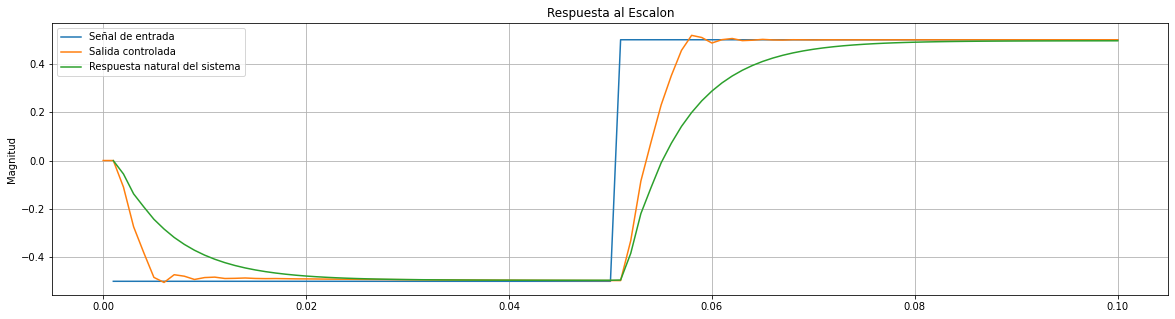

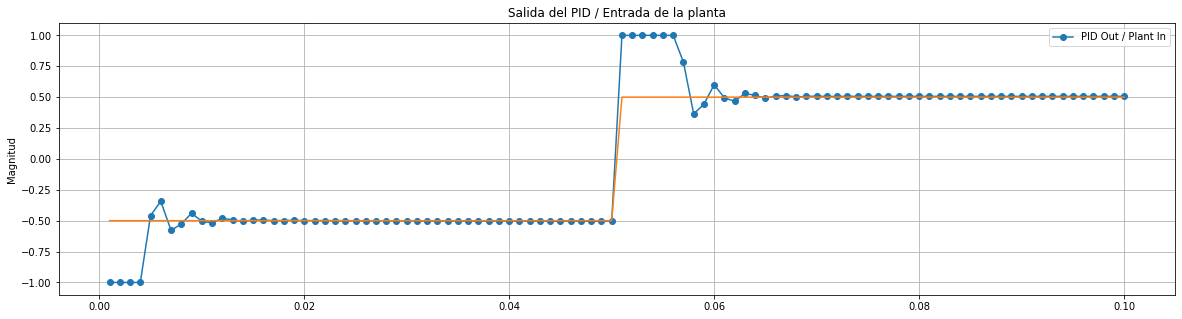

In [169]:
t = np.linspace(h, h * 100, 100)
r = np.concatenate((np.zeros(int(len(t) / 2)), np.ones(int(len(t) / 2))), axis=None) - 0.5

pid = PIDController(
    Kp=7, Ki=300.0, Kd=0.0005, T = 1.0 / SR_F_HZ,
    limMin = -1,
    limMax = 1,
    limMinInt = -10.0,
    deadZone = 0.0,
    tau = 1.0 / SR_F_HZ,
    bypassPid=False,
    limMaxInt = 10.0)


y_hz_pid, u = pid_controller_response(numz, denz, r, pid)
t_hz_open, y_hz_open = cnt.forced_response(hz, t, r)

plt.figure(figsize=(20, 5))
p_1 = plt.plot(t, r)
p_2 = plt.plot(np.arange(len(y_hz_pid)) * 1/ SR_F_HZ , y_hz_pid)
p_3 = plt.plot(t_hz_open, y_hz_open)
plt.ylabel('Magnitude')
plt.title('Step Response Comparison')
plt.grid()
plt.legend((p_1[0], p_2[0], p_3[0]), ('Reference Signal', 'Controlled Signal', 'OL Response'))
plt.show()


plt.figure(figsize=(20, 5))
plt.ylabel('Magnitud')
plt.grid()
plt.title('Salida del PID / Entrada de la planta')
plt.plot(t, u[2:], '-o', label='PID Out / Plant In')
plt.legend()
plt.plot(t, r, label='Señal de referencia')
plt.show()



In [170]:
off = len(t_hz_open) // 2
rt, _ = calc_risetime(t_hz_open[off:], y_hz_open[off:])
rt2, __ = calc_risetime((np.arange(len(y_hz_pid)) * 1/ SR_F_HZ)[off:], y_hz_pid[off:])
print(rt)
print(rt2)
overshoot = (max(y_hz_pid)/max(r) - 1) * 100
print(f'Overshoot: {overshoot}%')
print(f'Rise Time Improvement (simulation) {(1 - rt2/rt)*100}%')

0.4240112518188085
0.2694611686384689
Overshoot: 3.638270159450796%
Rise Time Improvement (simulation) 36.44952404385321%


## PID Result Analysis

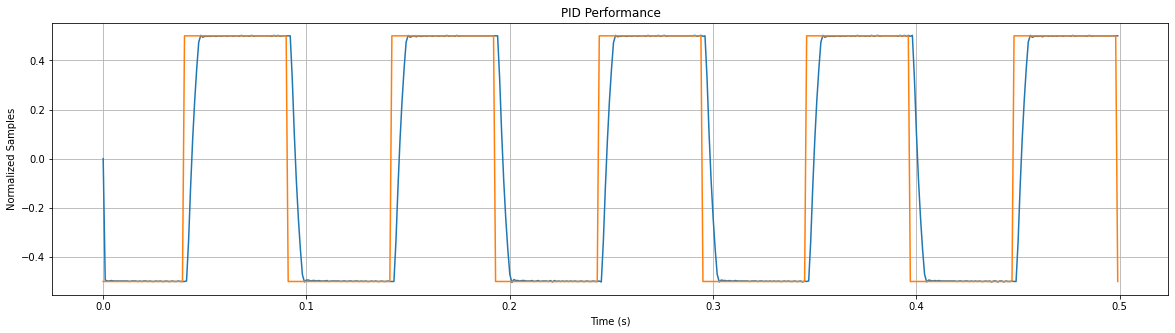

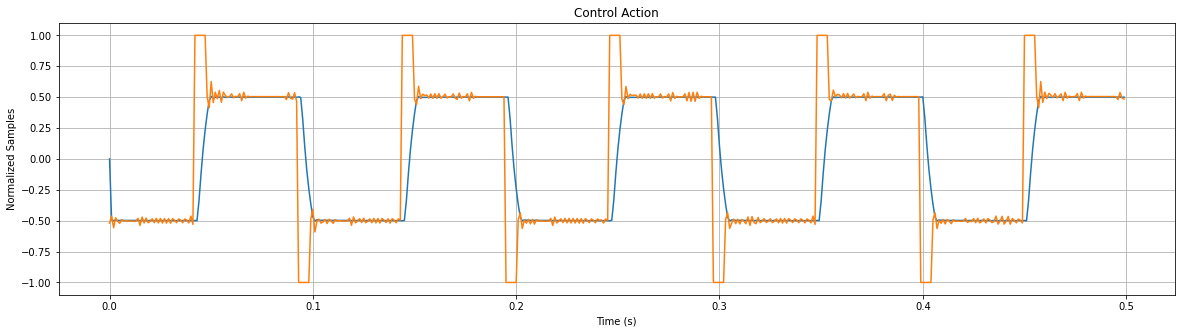

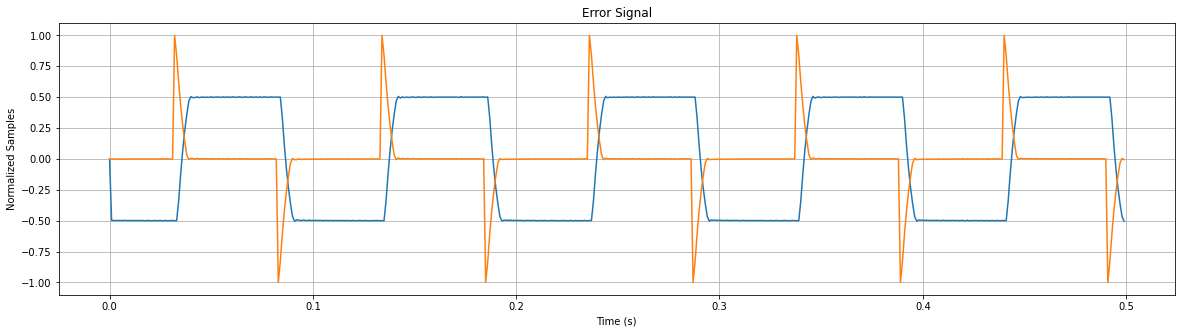

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files into pandas dataframes
error_df = pd.read_csv("csvs/pid_error.csv")
ctrl_action_df = pd.read_csv("csvs/pid_control_action.csv")
pid_tuned_df = pd.read_csv("csvs/pid_output.csv")


# Plot the error signal
plt.figure(figsize=(20, 5))
plt.plot(pid_tuned_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], pid_tuned_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(pid_tuned_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], pid_tuned_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Reference Signal')
plt.title("PID Performance")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()

# Plot the control action
plt.figure(figsize=(20, 5))
plt.plot(ctrl_action_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], ctrl_action_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(ctrl_action_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], ctrl_action_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='PID Output')
plt.title("Control Action")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()

# Plot the reference signal and control action
plt.figure(figsize=(20, 5))
plt.plot(error_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], error_df["ADC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Plant Response')
plt.plot(error_df["Time"][:SR_F_HZ//SQ_WAVE_F_HZ*5], error_df["DAC"][:SR_F_HZ//SQ_WAVE_F_HZ*5], label='Error')
plt.title("Error Signal")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.grid()
plt.show()


t_r = 3.9999999999995595 ms < 9.799999999999999
Overshoot 0.78%


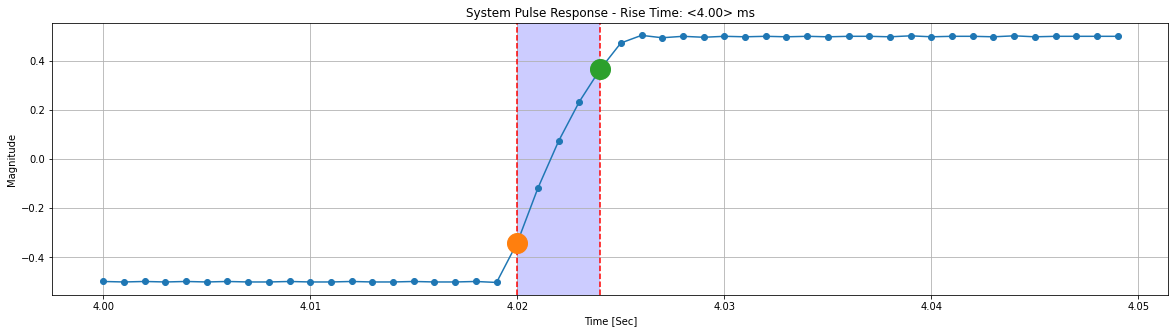

In [172]:
# Metrics
# Calculamos los límites para el risetime.
v10 = (pid_tuned_df['ADC'].max() - pid_tuned_df['ADC'].min())*.1 + pid_tuned_df['ADC'].min()
v90 = (pid_tuned_df['ADC'].max() - pid_tuned_df['ADC'].min())*.9 + pid_tuned_df['ADC'].min()

offset = 4000
data = np.array(pid_tuned_df['ADC'][offset:offset+(SR_F_HZ//SQ_WAVE_F_HZ//2)]) 
tme = np.array(pid_tuned_df['Time'][offset:offset+(SR_F_HZ//SQ_WAVE_F_HZ//2)]) 

# Cleanup missed samples
zero_indices = np.where(data == 0)[0]

# Replace zeros with previous value
for i in zero_indices:
    data[i] = data[i-1]

# Buscamos los instantes en los que ocurren.
t10_i = np.argmin(np.abs(data - v10)) 
t90_i = np.argmin(np.abs(data - v90))

# Calculamos el Risetime.
tr = abs(tme[t90_i] - tme[t10_i])
print(f't_r = {tr * 1000} ms < {14 * 0.7}')

# Graficamos.
plt.figure(figsize=(20, 5))
plt.plot(tme, data, '-o')
plt.axvline(tme[t10_i], color='red', linestyle='--')
plt.axvline(tme[t90_i], color='red', linestyle='--')
plt.axvspan(tme[t10_i], tme[t90_i], facecolor='blue', alpha=0.2)
plt.plot(tme[t10_i], data[t10_i], 'o', markersize=20)
plt.plot(tme[t90_i], data[t90_i], 'o', markersize=20)
plt.title(f'System Pulse Response - Rise Time: <{tr * 1000:.2f}> ms')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()


# Overshoot
osht = (pid_tuned_df['ADC'].max() / pid_tuned_df['DAC'].max() - 1.) * 100
print(f'Overshoot {osht:.2f}%')


| System/Controller Performance | Before Applying PID Controller | After Applying PID Controller |
|:------------------------------:|:------------------------------:|:------------------------------:|
|         Rise Time (ms)         |             12.0               |                4               |
|        Overshoot (%)          |               0                |              0.78              |

## Bonus: Control Action Simulation - Model Test 

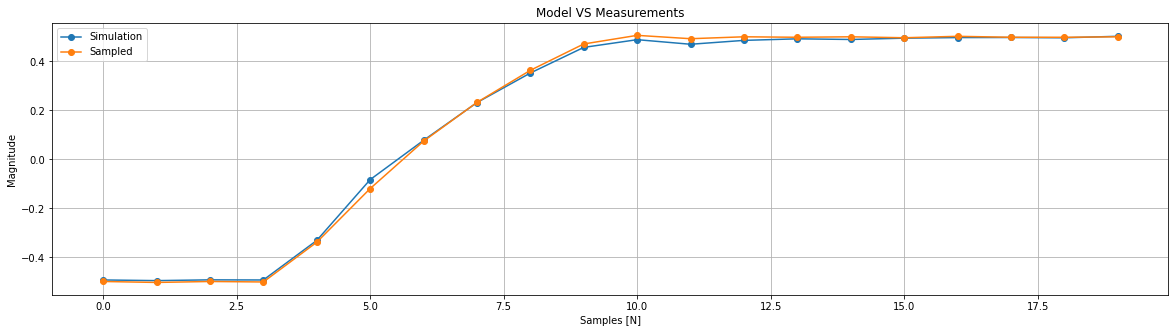

In [179]:
num = numz    
den = denz
input = np.array([0.5 if a > 0 else -0.5 for a in ctrl_action_df['DAC']]) 
a = np.array(den).flatten()
b = np.array(num).flatten()

n_inicial = len(a) - 1

y = np.zeros(len(input) + n_inicial)
r = np.concatenate((np.zeros(n_inicial), input), axis=None)
c = np.concatenate((np.zeros(n_inicial), ctrl_action_df['DAC']), axis=None)
u = np.zeros(len(input) + n_inicial)

for k in range(n_inicial, len(r)):

  for m in range(0, len(b)):
    y[k] = y[k] + (b[m] * u[k-m])
  
  for n in range(1, len(a)):
    y[k] = y[k] - a[n] * y[k-n]

  y[k] = y[k] / a[0]
  u[k] = c[k] 

plt.figure(figsize=(20, 5))
plt.title('Model VS Measurements')
plt.plot(y[n_inicial-1:][40:60], '-o', label='Simulation')
plt.plot(np.array(ctrl_action_df['ADC'])[40:60], '-o', label='Sampled')
plt.xlabel('Samples [N]')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

# Pole Placement - Simulation
* Pole placement based on RC-RC cascade model
* Using no observers, this requires to sample the voltage both at the output
of the plant and the intermediate RC voltage.
![plant](./img/Plant.png)
* State Model:

$A = \begin{bmatrix}
-\frac{1}{R_1 C_1}-\frac{1}{R_2 C_1} & \frac{1}{R_2 C_1} \\
\frac{1}{R_2 C_2} & -\frac{1}{R_2 C_2}
\end{bmatrix}$

$B = \begin{bmatrix}
\frac{1}{R_1 C_1} \\
0
\end{bmatrix}$

$C = \begin{bmatrix}
0 & 1
\end{bmatrix}$



K=[[[0.37964295 0.60778899]]]
K_0=1.9874319426885374


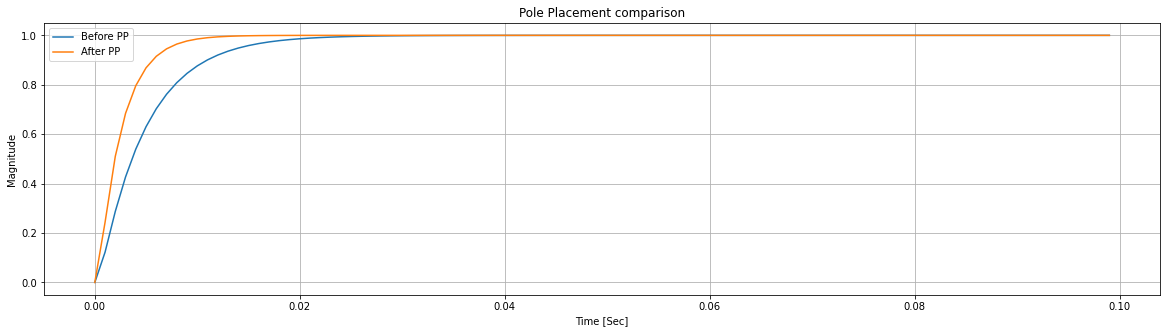

In [182]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt
import math as mt

# Define the system transfer function
R1 = 10e3
C1 = 100e-9
R2 = 10e3
C2 = 200e-9 


h = 1e-3
t = np.arange(0, .1, h)

A = [[-(1/R1+1/R2)/C1, 1/(R2*C1)], [1/(R2*C2), -1/(R2*C2)]]
B = [[1/(R1*C1)], [0]]
C = [[0, 1]]
sys = cnt.ss(A, B, C, 0)
sysd = cnt.c2d(sys, h)
sys_tf = cnt.ss2tf(sys)

def sim_ss(sys_disc, k=[[0, 0]], k0=1):
    x = np.zeros((len(sys_disc.A), len(t)+1))
    y = np.zeros((1, len(t)))
    u = np.ones((1, len(t)))

    for i in range(len(t)):
        x[:, i+1] = np.matmul(sys_disc.A, x[:, i]) - np.matmul(np.matmul(sys_disc.B, k), x[:, i])  + np.multiply(k0, np.matmul(sys_disc.B, u[:, i])) 
        y[:, i] = np.matmul(sys_disc.C, x[:,i])
    return x, y, u

def disc_dcgain(sys_disc):
  return np.matmul(np.matmul(sys_disc.C, np.linalg.inv(np.eye(2) - sys_disc.A)), sys_disc.B)[0, 0]  


plt.figure(figsize=(20, 5))

x, y, u = sim_ss(sysd)
plt.plot(t, y[0], label='Before PP')


P = cnt.pole(sys_tf)
Pd = np.exp(P*2*h)
K = cnt.place(sysd.A, sysd.B, [Pd[0], Pd[1]])
print(f'K=[{K}]')
x, y, u = sim_ss(sysd, K)
sysdlc = cnt.ss(sysd.A - np.matmul(sysd.B, K), sysd.B, sysd.C, sysd.D)

print(f'K_0={1 / disc_dcgain(sysdlc)}')

x, y, u = sim_ss(sysd, K, 1/disc_dcgain(sysdlc))
plt.plot(t, y[0], label='After PP')

plt.title('Pole Placement comparison')
plt.xlabel('Time [Sec]')
plt.ylabel('Magnitude')
plt.grid()
plt.legend()

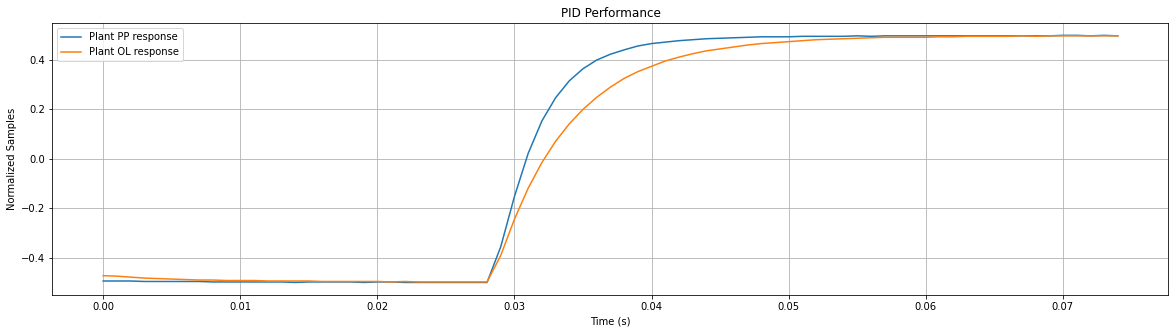

In [184]:
# Load the CSV files into pandas dataframes
pp_df = pd.read_csv("csvs/adcx2_dacx1.csv")
ol_df = pd.read_csv("csvs/step_resp.csv")

pp = extract_data(pp_df, periods=.75, samples_offset=10)
ol = extract_data(ol_df, periods=.75, samples_offset=72)

# Plot the error signal
plt.figure(figsize=(20, 5))
plt.title('Sampled Data')
plt.plot(pp['Time'], pp['ADC'], label='Plant PP response')
plt.plot(pp['Time'], ol['ADC'], label='Plant OL response')
plt.title("PID Performance")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.legend()
plt.grid()
plt.show()

Improvement: 41.66666666666671%


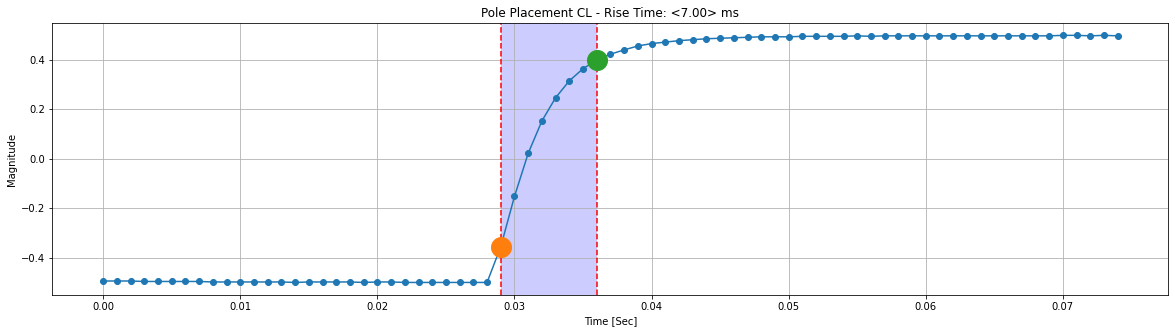

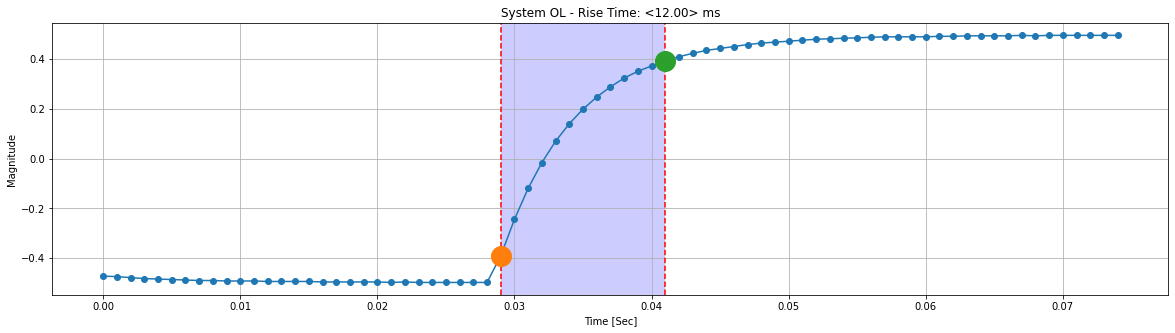

In [185]:
pptr = plot_risetime(pp, 'Pole Placement CL')
oltr = plot_risetime(ol, 'System OL')
print(f'Improvement: {(1-(pptr/oltr)) * 100}%')

# Pole Placement - Observer
Given the simplicity of the system, a `X1` observer can be implemented, which
avoids the need of sampling both states. The observer was designed based on the
A, B and C matrices, making use of the fact that C[0] equals 0 for this system,
which further simplifies the computation to estimate the `X1` state.

In the following test/analysis, the MCU pole placement algorithm is updated to
use `X2` the same as before, but `X1` is estimated based on the following equation
instead of being sampled.

$A = \begin{bmatrix}
-\frac{1}{R_1 C_1}-\frac{1}{R_2 C_1} & \frac{1}{R_2 C_1}\end{bmatrix}$

$B = \frac{1}{R_1 C_1} $

$X1_{hat}(n+1) = A[0] * X1_{hat}(n) + A[1] * X2 + B * U(n)$


jj

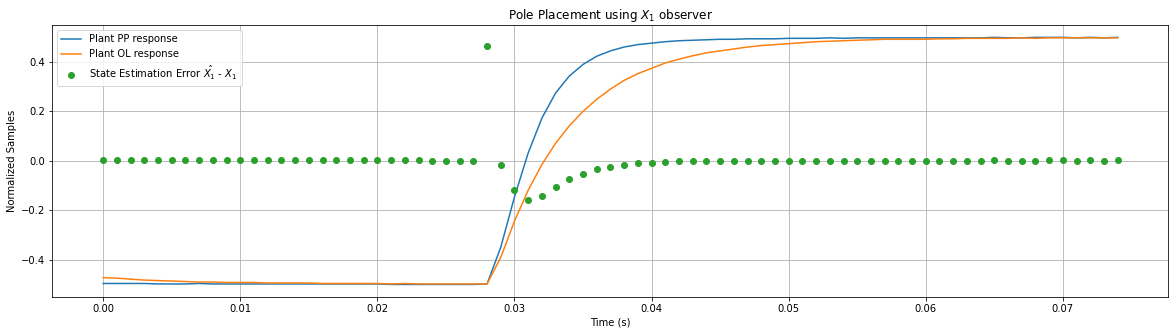

In [201]:
# Load the CSV files into pandas dataframes
pp_df = pd.read_csv("csvs/observer.csv")
ol_df = pd.read_csv("csvs/step_resp.csv")

pp = extract_data(pp_df, periods=.75, samples_offset=10)
ol = extract_data(ol_df, periods=.75, samples_offset=72)

# Plot the error signal
plt.figure(figsize=(20, 5))
plt.title('Sampled Data')
plt.plot(pp['Time'], pp['ADC'], label='Plant PP response')
plt.plot(pp['Time'], ol['ADC'], label='Plant OL response')
plt.plot(pp['Time'], pp['DAC'], 'o', label='State Estimation Error $\hat{X_1}$ - $X_1$')
plt.title("Pole Placement using $X_1$ observer")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Samples")
plt.legend()
plt.grid()
plt.show()